In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML,Image

# Simple Double pendulum using Lagrange's equation

Defines a DoublePendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

In [3]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Double-Pendulum.svg/294px-Double-Pendulum.svg.png?20080604080929')

Sample picture of double pendulum from Wikipedia. In cartesian coordinates the origin is chosen as the ceiling, $\hat{x}$ is the horizontal axis and $\hat{y}$ is the vertical axis. The notation used in this code is the same as the image except replace $\theta$ with $\phi$

To get the equations for energy to use Lagrange's equation we will be using Equations 11.37 and 11.38 from Taylor. These are as follows,

$\begin{align}
  U(\phi_1,\phi_2) = (m_1+m_2)gL_1(1-cos\phi_1)+m_2gL_2(1-cos\phi_2)
\end{align}$

and 

$\begin{align}
  T = \frac{1}{2}(m_1+m_2)L_1^2\dot{\phi_1}^2+m_2L_1L_2\dot{\phi_1}\dot{\phi_2}cos(\phi_1-\phi_2)+m_2gL_2(1-cos\phi_2)+\frac{1}{2}(m_1+m_2)L_2^2\dot{\phi_2}^2
\end{align}$

The Lagrangian is then,

$\begin{align}
  \mathcal{L} = \frac{1}{2}(m_1+m_2)L_1^2\dot{\phi_1}^2+\frac{1}{2}m_2L_2^2\dot{\phi_2}^2++m_2L_1L_2\dot{\phi_1}\dot{\phi_2}cos(\phi_1-\phi_2)+(m_1+m_2)gL_1cos\phi_1+m_2gL_2cos\phi_2
\end{align}$

The Euler Lagrange equations are found using,

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot{q_i}} - \frac{\partial\mathcal L}{\partial{q_i}}
  = 0
  \end{align}$ for $q_i$ = $\phi_1$, $\phi_2$

Solving these equations we get,

$\begin{align}
  g(m_1+m_2)sin\phi_1+L_2m_2sin(\phi_1-\phi_2)\dot{\phi_2^2}+L_1(m_1+m_2)\ddot{\phi_1}+L_2m_2cos(\phi_1-\phi_2)\ddot{\phi_2} = 0
\end{align}$

and 

$\begin{align}
  m_2(gsin\phi_2-L_1sin(\phi_1-\phi_2)\dot{\phi_1^2}+L_1cos(\phi_1-\phi_2)\ddot{\phi_1}+L_2\ddot{\phi_2}) = 0
\end{align}$

In order to use solve.ode we must have first order differential equations. These can be found by making the substituion
$z_1=\dot{\phi_1}$ and $z_2=\dot{\phi_2}$ with $\dot{z_1} = \ddot{\phi_1}$ and $\dot{z_2} = \ddot{\phi_2}$. Now we can solve for $\dot{z_1}$ and $\dot{z_2}$

$
\begin{align}
\dot{z}_1 &= \frac{g(m_1+m_2)\sin\phi_1+L_2m_2z_2^2\sin(\phi_1-\phi_2)+L_1m_2z_1^2\sin(\phi_1-\phi_2)\cos(\phi_1-\phi_2)-L_1(m_1+m_2)\dot{z}_1^2\sin(\phi_1-\phi_2)-g(m_1+m_2)\cos\phi_1\sin(\phi_1-\phi_2)}{-L_1(m_1+m_2)+L_2m_2\cos^2(\phi_1-\phi_2)}
\end{align}
$

and

$\begin{align}
\dot{z}_2=\frac{g (m_1 + m_2) cos(\phi_1 - \phi_2) sin\phi_1 + L_1 (m_1 + m_2) z_1^2 sin(\phi_1 - \phi_2) + \frac{1}{2} L_2 m_2 z_2^2 sin(2 (\phi_1 -\phi_2)) - 
 g (m_1+m_2) sin\phi_2}{L_2 (m_1 + m_2 - 
   m_2 cos(\phi_1 - \phi_2)^2)}
\end{align}$

These are the equations implemented in the class below

In [4]:
class DoublePendulum():
    """
     Pendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the First pendulum
    L2 : float
        length of the Second pendulum
    g : float
        gravitational acceleration at the earth's surface
    m1 : float
        mass of first pendulum
    m2 : float
        mass of second pendulum
    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1.,L2=1, m1=1.,m2=1, g=1.):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        (dphi1/dt,dphi1d/dt,dphi2/dt,dphi2d/dt)
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y(0) = phi1, y(1) = phi1d, y(2) = phi2, y(3) = phi2d
            
        Returns
        -------
        
        
        """
        phi1, x1, phi2, x2 = y
        x1d = (self.g*(self.m1+self.m2)*np.sin(phi1)+self.L2*self.m2*x2**2*np.sin(phi1-phi2)+self.L1*self.m2*x1**2*\
              np.cos(phi1-phi2)*np.sin(phi1-phi2)-self.g*self.m2*np.cos(phi1-phi2)*np.sin(phi2))/(-self.L1*self.m1-self.L1*\
                                                                                                 self.m2+self.L1*self.m2*np.cos(phi1-phi2)**2)
        x2d = (self.g*(self.m1+self.m2)*np.sin(phi1)*np.cos(phi1-phi2)+self.L1*(self.m1+self.m2)*x1**2*\
               np.sin(phi1-phi2)+0.5*self.L2*self.m2*x2**2*np.sin(2*(phi1-phi2))-self.g*(self.m1+self.m2)*np.sin(phi2))/\
                (self.L2*(self.m1+self.m2-self.m2*np.cos(phi1-phi2)**2))
    
        phi1d = x1
        phi2d = x2
        return phi1d, x1d, phi2d, x2d
    def solve_ode(self, t_pts, phi1_0, phi1d_0, phi2_0, phi2d_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = (phi1_0, phi1d_0, phi2_0, phi2d_0) 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1d, phi2, phi2d = solution.y

        return phi1, phi1d, phi2, phi2d

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [7]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50
delta_t = 0.001
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
#set parameters
L1 = 1.
L2 = 1
g = 1.
m1 = 1.
m2 = 1

# Instantiate a double pendulum 
d1 = DoublePendulum(L1=L1,m1=m1,m2=m2,g=g)


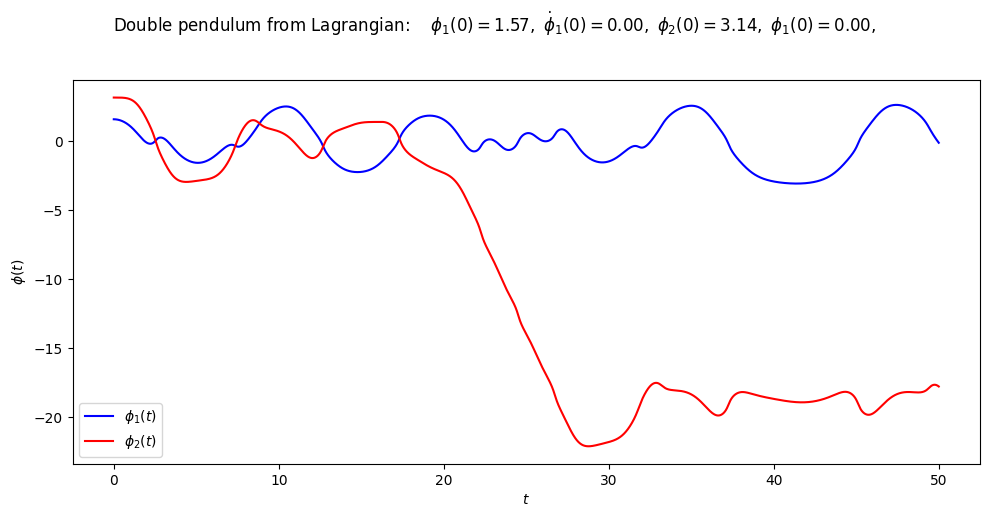

In [8]:
#set initial conditions
phi1_0 = np.pi/2
phi1d_0 = 0
phi2_0 = np.pi
phi2d_0 = 0

phi1, phi1d, phi2, phi2d = d1.solve_ode(t_pts,phi1_0,phi1d_0,phi2_0,phi2d_0)
#plotting time
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:   ' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1d_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\phi_1(0) = {phi2d_0:.2f},$'
fig.suptitle(overall_title, va = 'baseline')

ax_a = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts, t_start, t_end)
plot_y_vs_x(t_pts[start:stop], phi1[start:stop],
           axis_labels = phi_vs_time_labels,
           color='blue',
           label=r'$\phi_1(t)$',
           ax = ax_a)
plot_y_vs_x(t_pts[start:stop], phi2[start:stop],
           axis_labels = phi_vs_time_labels,
           color='red',
           label=r'$\phi_2(t)$',
           ax = ax_a)
fig.tight_layout()

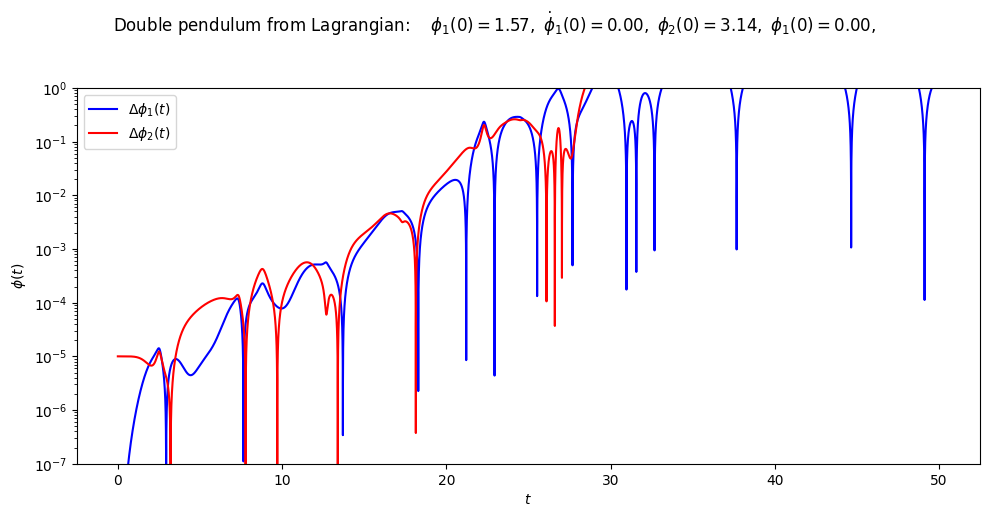

In [9]:
#run the same double  pendulum with a small perturbation to check whether the solution is chaotic
phi1b, phi1db, phi2b, phi2db = d1.solve_ode(t_pts,phi1_0,phi1d_0,phi2_0-0.00001,phi2d_0)

#plotting time, the sequel
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:   ' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1d_0:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\phi_1(0) = {phi2d_0:.2f},$'
fig.suptitle(overall_title, va = 'baseline')
#plotting delta phi between the two systems with slightly different initial conditions
ax_a = fig.add_subplot(1,1,1)
start,stop = start_stop_indices(t_pts, t_start, t_end)
plot_y_vs_x(t_pts[start:stop], np.abs(phi1[start:stop]-phi1b[start:stop]),
           axis_labels = phi_vs_time_labels,
           color='blue', semilogy=True,
           label=r'$\Delta\phi_1(t)$',
           ax = ax_a)
plot_y_vs_x(t_pts[start:stop], np.abs(phi2[start:stop]-phi2b[start:stop]),
           axis_labels = phi_vs_time_labels,
           color='red', semilogy=True,
           label=r'$\Delta\phi_2(t)$',
           ax = ax_a)
ax_a.set_ylim(1.e-7,1.)
fig.tight_layout()

As time increases the difference between the two pendulums grows exponentially. Meaning that the movement must be chaotic. If it were not a small perturbation would not disturb the system to this extent

In [10]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 400
delta_t = 0.05
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
#set parameters

#resolve the odes with more time points for animation
phi1, phi1d, phi2, phi2d = d1.solve_ode(t_pts,phi1_0,phi1d_0,phi2_0,phi2d_0)
phi1b, phi1db, phi2b, phi2db = d1.solve_ode(t_pts,phi1_0,phi1d_0,phi2_0-0.00001,phi2d_0)

In [11]:
def coords(x0,y0,phi,L):
    """
    Convert the angle and length of a pendulum to cartesian coords  w.r.t initial conditions
    """
    x = x0+np.sin(phi)
    y = y0-np.cos(phi)
    return x,y

In [12]:
%%capture
x_min = -3.2
x_max = -x_min
y_min = -3.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='Double Pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min,x_max)
ax_anim.set_ylim(y_min,y_max)


x0,y0 = 0.,0.
pt0_anim, = ax_anim.plot(x0,y0,'o', markersize=6,color='black')

x1,y1 = coords(x0,y0,phi1[0],d1.L1)
pt1_anim, = ax_anim.plot(x1,y1,'o', markersize=12,color='blue')
ln1_anim, = ax_anim.plot([x0,x1],[y0,y1],color='blue',lw=3)

x2,y2 = coords(x1,y1,phi2[0],d1.L2)
pt2_anim, = ax_anim.plot(x2,y2,'o', markersize=12,color='blue')
ln2_anim, = ax_anim.plot([x1,x2],[y1,y2],color='blue',lw=3)

x1b,y1b = coords(x0,y0,phi1b[0],d1.L1)
pt1b_anim, = ax_anim.plot(x1b,y1b,'o', markersize=12,color='red')
ln1b_anim, = ax_anim.plot([x0,x1b],[y0,y1b],color='red',lw=3)

x2b,y2b = coords(x1b,y1b,phi2b[0],d1.L2)
pt2b_anim, = ax_anim.plot(x2b,y2b,'o', markersize=12,color='red')
ln2b_anim, = ax_anim.plot([x1b,x2b],[y1b,y2b],color='red',lw=3)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [13]:
def animatedPendulum(i):
    """
    This function creates each frame of the animation. i is used to iterate frame by frame
    """
    i_skip=i*2
    x0,y0 = 0.,0.
    pt0_anim.set_data(x0,y0)
    
    x1,y1 = coords(x0,y0,phi1[i_skip],d1.L1)
    pt1_anim.set_data(x1,y1)
    ln1_anim.set_data([x0,x1],[y0,y1])
    
    x2,y2 = coords(x1,y1,phi2[i_skip],d1.L2)
    pt2_anim.set_data(x2,y2)
    ln2_anim.set_data([x1,x2],[y1,y2])  
    
    x1b,y1b = coords(x0,y0,phi1b[i_skip],d1.L1)
    pt1b_anim.set_data(x1b,y1b)
    ln1b_anim.set_data([x0,x1b],[y0,y1b])
    
    x2b,y2b = coords(x1b,y1b,phi2b[i_skip],d1.L2)
    pt2b_anim.set_data(x2b,y2b)
    ln2b_anim.set_data([x1b,x2b],[y1b,y2b]) 
    
    return (pt0_anim,pt1_anim,ln1_anim,pt2_anim,ln2_anim,pt1b_anim,ln1b_anim,pt2b_anim,ln2b_anim)

In [14]:
frame_interval = 20. #time between frames
frame_number =1001 #number of frames
anim = animation.FuncAnimation(fig_anim,animatedPendulum,init_func=None,frames=frame_number,interval = frame_interval,
                               blit=True,repeat=False)

In [15]:
HTML(anim.to_jshtml()) #show animation

Note that as time goes on the two pendulums start to widly vary. This shows the chaotic behavior